# Deep Learning MTH 5320 
## Homework 3
## 12/6/2023
## By Josias Moukpe

## Object Detection Model Assignment

### Dataset Prep and Preprocessing (20 points)
- Collect or create a dataset of images containing the objects you want to detect annotated with bounding boxes.
- Implement data preprocessing techniques, including:
  - Resizing images
  - Normalizing pixels
- Hint: You can find pre-annotated datasets for download on [Roboflow](https://github.com/roboflow/supervision).

### Model Architecture (30 points)
- Train a YOLOv8 model on your selected dataset using the public repository available at [Ultralytics](https://github.com/ultralytics/ultralytics).
- Monitor the training progress and use appropriate techniques to prevent overfitting.
- Conduct at least 3 tuning experiments.

### Evaluation (20 points)
- Evaluate your trained model's performance on a test dataset using mAP (mean Average Precision).
- Visualize the model's predictions on sample images.
- Analyze the model's performance, discussing any specific failure modes on your test dataset.

In [1]:
# Import libraries
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mpimg
from pathlib import Path
from typing import Any, Dict
%matplotlib inline


In [2]:
# Helper functions
def plot_training_results(training_result: Any) -> None:
    """
    Plots the training results from a YOLOv8 model training session.

    Args:
    training_result (Any): The training result object from a YOLOv8 model training. 
                           It must have a 'save_dir' attribute.

    This function looks for 'results.png' in the specified directory and plots it using matplotlib.
    """
    # Extract the save directory from the training result object
    save_dir = training_result.save_dir

    # Path to the training results image
    results_path = Path(save_dir) / 'results.png'

    print("Training Results:")
    # Check if the file exists and plot it
    if results_path.exists():
        img = mpimg.imread(str(results_path))
        plt.figure(figsize=(10, 8))  # Adjust the figure size
        plt.imshow(img)
        plt.axis('off')
        plt.title('Training Results', fontsize=16)
        plt.show()
    else:
        print("Training results image not found.")


def plot_evaluation_results(test_result: Any) -> None:
    """
    Plots the confusion matrix and validation batch images from the test results of a YOLOv8 model.

    Args:
    test_result (Any): The test result object from a YOLOv8 model evaluation. It must have a 'save_dir' attribute.

    This function looks for 'confusion_matrix_normalized.png' and 'val_batchX_*' images in the specified directory,
    and plots them using matplotlib.
    """
    # Extract the save directory from the test result object
    save_dir = test_result.save_dir

    # Plot the confusion matrix
    cm_path = Path(save_dir) / 'confusion_matrix_normalized.png'
    print("Confusion Matrix:")
    if cm_path.exists():
        img = mpimg.imread(str(cm_path))
        plt.figure(figsize=(10, 8))  # Adjust the figure size
        plt.imshow(img)
        plt.axis('off')
        plt.title('Confusion Matrix', fontsize=16)
        plt.show()
    else:
        print("Confusion matrix not found.")

    
    # Plot validation batch images
    print("Sample Test Images:")
    for val_img_path in Path(save_dir).glob('val_batch*_labels.jpg'):
        pred_img_path = Path(str(val_img_path).replace('_labels.jpg', '_pred.jpg'))

        if pred_img_path.exists():
            img_label = mpimg.imread(str(val_img_path))
            img_pred = mpimg.imread(str(pred_img_path))

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(img_label)
            axs[0].axis('off')
            axs[0].set_title('Labels')

            axs[1].imshow(img_pred)
            axs[1].axis('off')
            axs[1].set_title('Predictions')
        
            plt.show()
        else:
            print(f"Prediction image not found for {val_img_path}.")


def print_evaluation_results(test_result: Any, experiment_name: str) -> None:
    """
    Prints the evaluation results from a YOLOv8 model testing session.

    Args:
    test_result (Any): The test result object from a YOLOv8 model evaluation. 
                       It must have a 'results_dict' attribute containing the evaluation metrics.
    experiment_name (str): The name of the experiment for which the evaluation was done.
    """
    print(f"Evaluation Results for {experiment_name}:")
    for key, value in test_result.results_dict.items():
        print(f"{key:20}: {value:.4f}")

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce RTX 3060


In [4]:
# configs
SEED = 42

In [5]:
# OCR dataset downloaded from Roboflow in Yolo v8 format
local_ocr_ds_path = 'D:/College/Fall2023/DeepLearning/yolo_ocr'
local_ocr_ds_yaml_path = 'D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml'
PROJECT_NAME = 'yolov8n_ocr'

In [6]:
# display the yaml file
with open(local_ocr_ds_yaml_path) as f:
    print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 36
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

roboflow:
  workspace: w251ocr
  project: ocr-oy9a7
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/w251ocr/ocr-oy9a7/dataset/1


## OCR Dataset
- The dataset is a collection of 6076 open character recognition images from various number plates. 
- It contains 36 classes of characters (A-Z, 0-9) and 1 class for the background.
- The dataset is split into 70% training, 20% validation, and 10% test sets.
- The detection labels are per characters and in Yolo V8 format
- The task is Object Detection

### Useful Links
- [OCR Dataset](https://universe.roboflow.com/w251ocr/ocr-oy9a7)
- [Yolo V8](https://docs.ultralytics.com/models/yolov8/)
- [Yolo V6](https://docs.ultralytics.com/models/yolov6/)
- [RT-DETR](https://docs.ultralytics.com/models/rtdetr/)
- [Modes Documentation](https://docs.ultralytics.com/modes/)

##### Experiment 1
- Testing baseline default hyperparameters
- To prevent overfitting, I use early stopping and weight decay
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library


In [7]:
# loading pre-trained yolov8 model from ultralytics
model_exp1 = YOLO('yolov8n.pt')
# display the model architecture
model_exp1

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [8]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS = 10  # Number of training epochs
BATCH = 8  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-2  # Initial learning rate
FinalLR = 1e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = model_exp1.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_152440
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_152440, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

wandb: Currently logged in as: erud1t3. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\train\labels.cache... 4245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4245/4245 [00:00<?, ?it/s]

train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\03c3dfc7e998b8562_jpg.rf.3d9d76c2437bcfb5cf433c0b6306d1ac.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\185d5dfa193c4ced_jpg.rf.b3d2ab34086b9e8f050b514cc22b4b9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\24c1fc0bf63da8153_jpg.rf.bd40f6e750b1a7990a9945aadddc1ef1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\421ca0ce7f9329622_jpg.rf.4e25470bde67152fea6834e88e803708.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\4572990fd64bb6be3_jpg.rf.7ce23d5cd8b919a7832485c4815d97c8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\492f6d607aae58c12_jpg.rf.44d8f6885cd8664eeff661809ad807ab.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\Co


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\valid\labels.cache... 1221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1221/1221 [00:00<?, ?it/s]

val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\0ecee0dd32848030_jpg.rf.ffe2fb185ba29646fcf16eacf0e99021.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\22deb87614a920e6_jpg.rf.a72d572c1920415b880c030e7b1a17e6.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\dcb210b4cae8edf22_jpg.rf.286248320e4fe0f26c75339865578ccc.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\f7f068d4fb49a4f34_jpg.rf.8856a3518481e9dcc022b1a802a966cd.jpg: 1 duplicate labels removed


Plotting labels to yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.55G      1.231       2.35      1.187         21        640: 100%|██████████| 531/531 [01:14<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:20<00:00,  3.75it/s]


                   all       1221       7890      0.448      0.535      0.455      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.56G      1.127      1.335      1.158         31        640: 100%|██████████| 531/531 [01:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.22it/s]


                   all       1221       7890      0.762      0.748      0.786      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.56G      1.046      1.037      1.117         34        640: 100%|██████████| 531/531 [01:05<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.38it/s]


                   all       1221       7890      0.814      0.767       0.84      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.56G     0.9731     0.8642      1.086         29        640: 100%|██████████| 531/531 [01:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.01it/s]


                   all       1221       7890      0.871      0.782      0.868      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.55G      0.954     0.8092      1.073         35        640: 100%|██████████| 531/531 [01:01<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  5.94it/s]


                   all       1221       7890      0.867      0.788      0.867      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.56G     0.9036     0.7318      1.051         28        640: 100%|██████████| 531/531 [01:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.11it/s]

                   all       1221       7890      0.905      0.836      0.906      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.56G     0.8707     0.6685      1.034         31        640: 100%|██████████| 531/531 [01:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.16it/s]


                   all       1221       7890      0.917      0.836       0.91      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.56G     0.8506     0.6128      1.026         28        640: 100%|██████████| 531/531 [01:05<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.05it/s]


                   all       1221       7890      0.911      0.863      0.928      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.56G     0.8155     0.5774      1.006         23        640: 100%|██████████| 531/531 [01:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.43it/s]

                   all       1221       7890      0.934      0.872      0.936      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.56G     0.7864     0.5389     0.9929         32        640: 100%|██████████| 531/531 [01:01<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.24it/s]

                   all       1221       7890      0.928      0.881      0.941      0.732



10 epochs completed in 0.228 hours.
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440\weights\last.pt, 6.2MB
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440\weights\best.pt, 6.2MB

Validating yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:14<00:00,  5.18it/s]


                   all       1221       7890      0.927      0.881      0.941      0.732
Speed: 0.7ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_152440


lr/pg0,█▅▂▂▂▁▁▁▁▁
lr/pg1,▂▆█▇▇▆▅▃▂▁
lr/pg2,▂▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▆▇▇▇▇████
metrics/mAP50-95(B),▁▅▆▇▇▇▇███
metrics/precision(B),▁▆▆▇▇█████
metrics/recall(B),▁▅▆▆▆▇▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▃▂▂▁▁


Training Results:


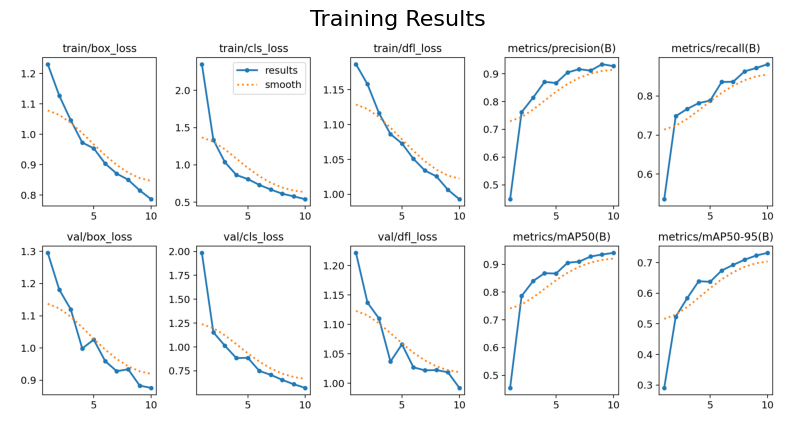

In [9]:
# display the sum training results
plot_training_results(training_results)

In [10]:
# Eval parameters
VAL_BATCH = 64
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = model_exp1.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\test\labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:09<00:00,  8.24it/s]


                   all        610       3954      0.891      0.857       0.91      0.682
Speed: 0.7ms preprocess, 5.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_1524402


In [11]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

Evaluation Results for baseline_yolov8n_ocr_20231206_152440:
metrics/precision(B): 0.8907
metrics/recall(B)   : 0.8569
metrics/mAP50(B)    : 0.9102
metrics/mAP50-95(B) : 0.6824
fitness             : 0.7052


Confusion Matrix:


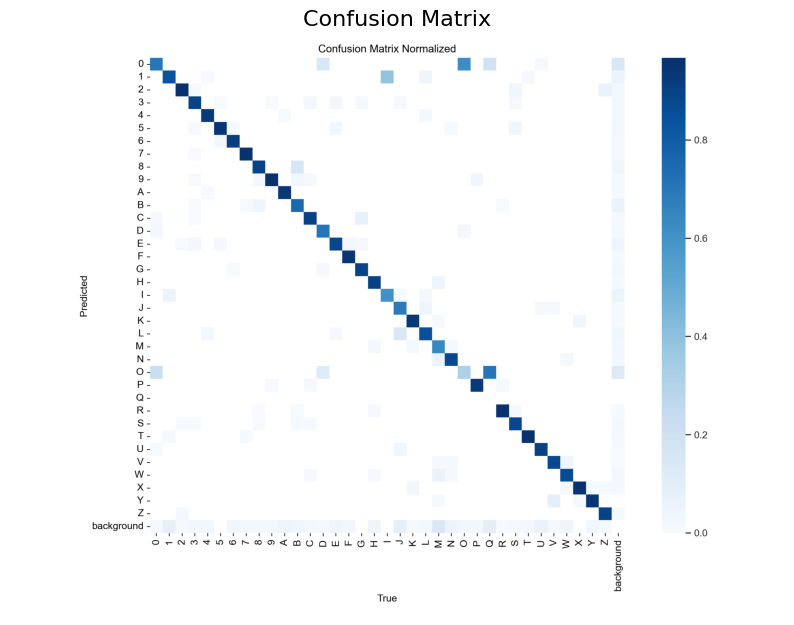

Sample Test Images:


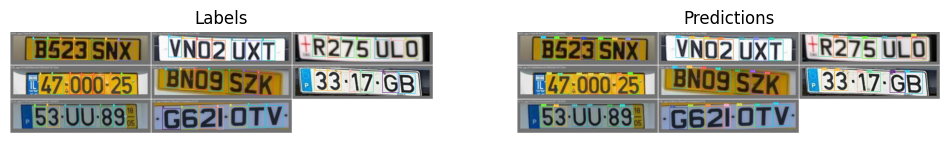

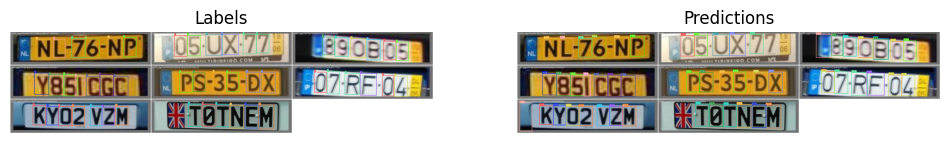

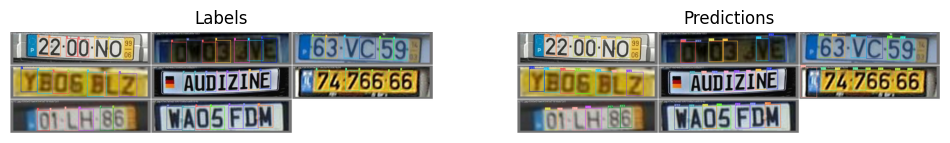

In [12]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

At mAP50 = 0.9102, our model exp1 is doing ok. However, we can see from the confusion plot that this model exp 1 is struggling with 0, O and Q as they are very similar

##### Experiment 2
- Testing following hyperparameter updates
  - Lowering the initial learning rate to 1e-3 and final learning rate to 5e-2
  - Increasing the batch size to 32
- To prevent overfitting, I use early stopping, weight decay, and dropout
- Image resizing (to IMGSZ) and normalization (to [0, 1]) is handle by ultralytics library

In [13]:
# loading pre-trained yolov8 model from ultralytics
model_exp2 = YOLO('yolov8n.pt')
# display the model architecture
model_exp2

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [15]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS = 10  # Number of training epochs
BATCH = 32  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = model_exp2.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_154850
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=10, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_154850, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

train: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\train\labels.cache... 4245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4245/4245 [00:00<?, ?it/s]

train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\03c3dfc7e998b8562_jpg.rf.3d9d76c2437bcfb5cf433c0b6306d1ac.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\185d5dfa193c4ced_jpg.rf.b3d2ab34086b9e8f050b514cc22b4b9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\24c1fc0bf63da8153_jpg.rf.bd40f6e750b1a7990a9945aadddc1ef1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\421ca0ce7f9329622_jpg.rf.4e25470bde67152fea6834e88e803708.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\4572990fd64bb6be3_jpg.rf.7ce23d5cd8b919a7832485c4815d97c8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\492f6d607aae58c12_jpg.rf.44d8f6885cd8664eeff661809ad807ab.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\Co


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\valid\labels.cache... 1221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1221/1221 [00:00<?, ?it/s]

val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\0ecee0dd32848030_jpg.rf.ffe2fb185ba29646fcf16eacf0e99021.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\22deb87614a920e6_jpg.rf.a72d572c1920415b880c030e7b1a17e6.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\dcb210b4cae8edf22_jpg.rf.286248320e4fe0f26c75339865578ccc.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\f7f068d4fb49a4f34_jpg.rf.8856a3518481e9dcc022b1a802a966cd.jpg: 1 duplicate labels removed


Plotting labels to yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         5G      1.091      3.086      1.131        117        640: 100%|██████████| 133/133 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


                   all       1221       7890      0.325      0.421       0.28      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.65G     0.9421      1.483      1.046        124        640: 100%|██████████| 133/133 [00:40<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


                   all       1221       7890      0.697      0.684       0.73      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.64G     0.8735      0.941      1.016        138        640: 100%|██████████| 133/133 [00:38<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


                   all       1221       7890      0.811      0.777      0.844      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.71G     0.8444     0.7789      1.002        126        640: 100%|██████████| 133/133 [00:38<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


                   all       1221       7890      0.882      0.795      0.882      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.63G     0.8057     0.7001     0.9849        138        640: 100%|██████████| 133/133 [00:37<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


                   all       1221       7890      0.901      0.841      0.903      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.63G     0.7876     0.6406     0.9694        128        640: 100%|██████████| 133/133 [00:38<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


                   all       1221       7890      0.913      0.842      0.911      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.63G     0.7496     0.5977     0.9616        131        640: 100%|██████████| 133/133 [00:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


                   all       1221       7890      0.914      0.864      0.919      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.63G     0.7254     0.5453     0.9525        112        640: 100%|██████████| 133/133 [00:38<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]

                   all       1221       7890      0.942       0.88      0.933      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.63G     0.6986     0.5189     0.9382        113        640: 100%|██████████| 133/133 [00:37<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


                   all       1221       7890      0.943       0.89      0.941      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.63G     0.6782     0.4858     0.9307        130        640: 100%|██████████| 133/133 [00:37<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all       1221       7890      0.938      0.906      0.948      0.745

10 epochs completed in 0.159 hours.
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850\weights\last.pt, 6.3MB
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850\weights\best.pt, 6.3MB

Validating yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all       1221       7890      0.943      0.891      0.941      0.751
Speed: 0.8ms preprocess, 1.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_154850


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▂▅█▇▇▆▅▃▂▁
lr/pg2,▂▅█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▆▇▇██████
metrics/mAP50-95(B),▁▅▆▇▇▇████
metrics/precision(B),▁▅▇▇██████
metrics/recall(B),▁▅▆▇▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▃▃▂▂▁▁


Training Results:


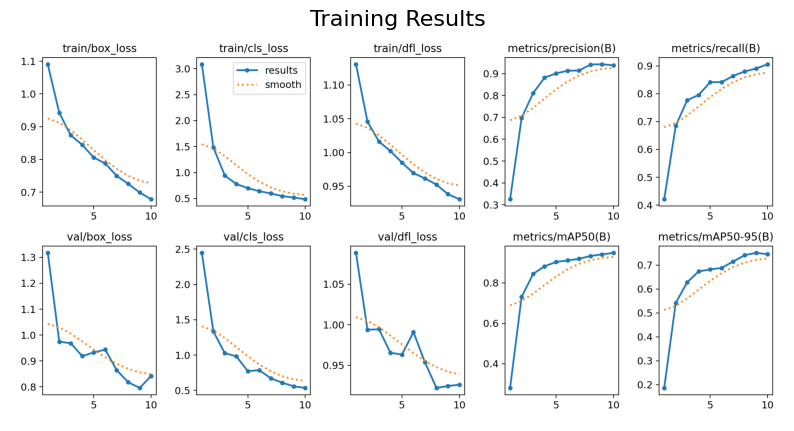

In [16]:
# display the sum training results
plot_training_results(training_results)

In [17]:
# Eval parameters
VAL_BATCH = 64
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = model_exp2.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\test\labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


                   all        610       3954      0.915      0.868      0.919      0.712
Speed: 0.8ms preprocess, 3.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_1548502


In [18]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

Evaluation Results for baseline_yolov8n_ocr_20231206_154850:
metrics/precision(B): 0.9147
metrics/recall(B)   : 0.8680
metrics/mAP50(B)    : 0.9187
metrics/mAP50-95(B) : 0.7119
fitness             : 0.7325


Confusion Matrix:


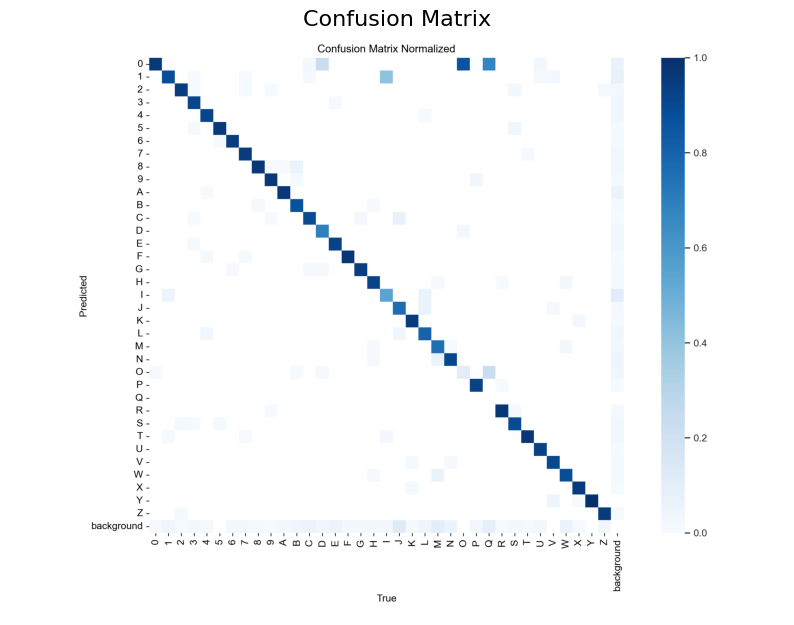

Sample Test Images:


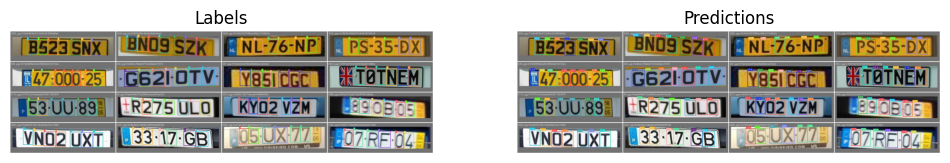

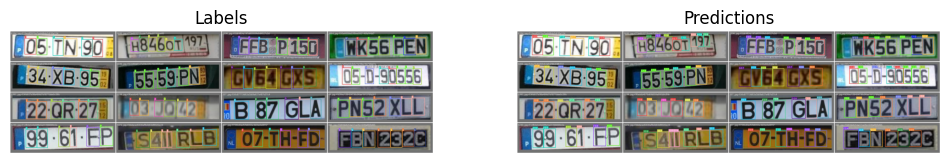

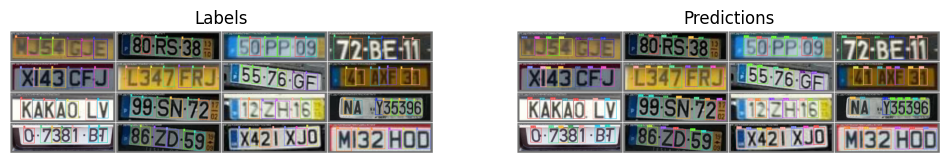

In [19]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

At mAP50 = 0.9187, our model exp2 is doing better than model exp 1 (0.9102). However, we can see from the confusion plot that this model exp 2 is still struggling with 0, O and Q. 

##### Experiment 3
- Testing following hyperparameter updates
   - Adding dropout of 0.2

In [7]:
# loading pre-trained yolov8 model from ultralytics
model_exp3 = YOLO('yolov8n.pt')
# display the model architecture
model_exp3

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [8]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS = 10  # Number of training epochs
BATCH = 32  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.2  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = model_exp3.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_161127
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=10, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_161127, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

wandb: Currently logged in as: erud1t3. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\train\labels.cache... 4245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4245/4245 [00:00<?, ?it/s]

train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\03c3dfc7e998b8562_jpg.rf.3d9d76c2437bcfb5cf433c0b6306d1ac.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\185d5dfa193c4ced_jpg.rf.b3d2ab34086b9e8f050b514cc22b4b9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\24c1fc0bf63da8153_jpg.rf.bd40f6e750b1a7990a9945aadddc1ef1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\421ca0ce7f9329622_jpg.rf.4e25470bde67152fea6834e88e803708.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\4572990fd64bb6be3_jpg.rf.7ce23d5cd8b919a7832485c4815d97c8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\492f6d607aae58c12_jpg.rf.44d8f6885cd8664eeff661809ad807ab.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\Co


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\valid\labels.cache... 1221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1221/1221 [00:00<?, ?it/s]

val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\0ecee0dd32848030_jpg.rf.ffe2fb185ba29646fcf16eacf0e99021.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\22deb87614a920e6_jpg.rf.a72d572c1920415b880c030e7b1a17e6.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\dcb210b4cae8edf22_jpg.rf.286248320e4fe0f26c75339865578ccc.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\f7f068d4fb49a4f34_jpg.rf.8856a3518481e9dcc022b1a802a966cd.jpg: 1 duplicate labels removed


Plotting labels to yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.97G      1.091      3.086      1.131        117        640: 100%|██████████| 133/133 [00:44<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


                   all       1221       7890      0.325      0.421       0.28      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.64G     0.9421      1.483      1.046        124        640: 100%|██████████| 133/133 [00:41<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


                   all       1221       7890      0.697      0.684       0.73      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.63G     0.8735      0.941      1.016        138        640: 100%|██████████| 133/133 [00:36<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


                   all       1221       7890      0.811      0.777      0.844      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       4.7G     0.8444     0.7789      1.002        126        640: 100%|██████████| 133/133 [00:37<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


                   all       1221       7890      0.882      0.795      0.882      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.62G     0.8057     0.7001     0.9849        138        640: 100%|██████████| 133/133 [00:39<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


                   all       1221       7890      0.901      0.841      0.903      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.62G     0.7876     0.6406     0.9694        128        640: 100%|██████████| 133/133 [00:38<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

                   all       1221       7890      0.913      0.842      0.911      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.63G     0.7496     0.5977     0.9616        131        640: 100%|██████████| 133/133 [00:40<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


                   all       1221       7890      0.914      0.864      0.919      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.62G     0.7254     0.5453     0.9525        112        640: 100%|██████████| 133/133 [00:44<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


                   all       1221       7890      0.942       0.88      0.933      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.62G     0.6986     0.5189     0.9382        113        640: 100%|██████████| 133/133 [00:41<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]

                   all       1221       7890      0.943       0.89      0.941      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.62G     0.6782     0.4858     0.9307        130        640: 100%|██████████| 133/133 [00:40<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


                   all       1221       7890      0.938      0.906      0.948      0.745

10 epochs completed in 0.161 hours.
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127\weights\last.pt, 6.2MB
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127\weights\best.pt, 6.2MB

Validating yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


                   all       1221       7890      0.943      0.891      0.941      0.751
Speed: 0.9ms preprocess, 1.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_161127


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▂▅█▇▇▆▅▃▂▁
lr/pg2,▂▅█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▆▇▇██████
metrics/mAP50-95(B),▁▅▆▇▇▇████
metrics/precision(B),▁▅▇▇██████
metrics/recall(B),▁▅▆▇▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▃▃▂▂▁▁


Training Results:


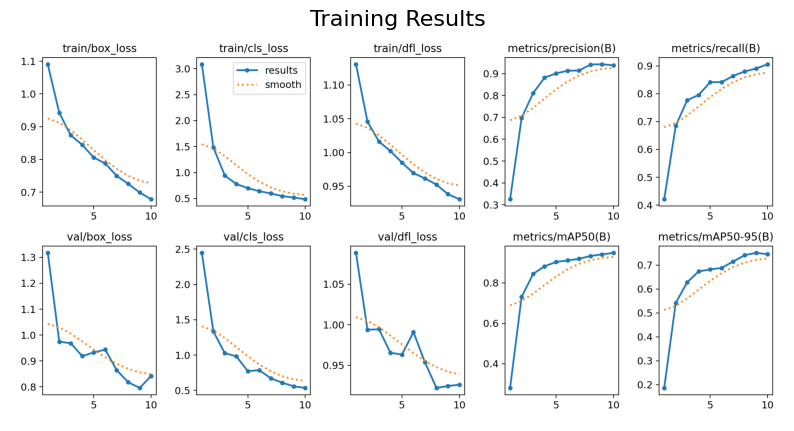

In [9]:
# display the sum training results
plot_training_results(training_results)

In [10]:
# Eval parameters
VAL_BATCH = 64
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = model_exp3.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\test\labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


                   all        610       3954      0.915      0.868      0.919      0.712
Speed: 0.7ms preprocess, 4.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_1611272


In [11]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

Evaluation Results for baseline_yolov8n_ocr_20231206_161127:
metrics/precision(B): 0.9147
metrics/recall(B)   : 0.8680
metrics/mAP50(B)    : 0.9187
metrics/mAP50-95(B) : 0.7119
fitness             : 0.7325


Confusion Matrix:


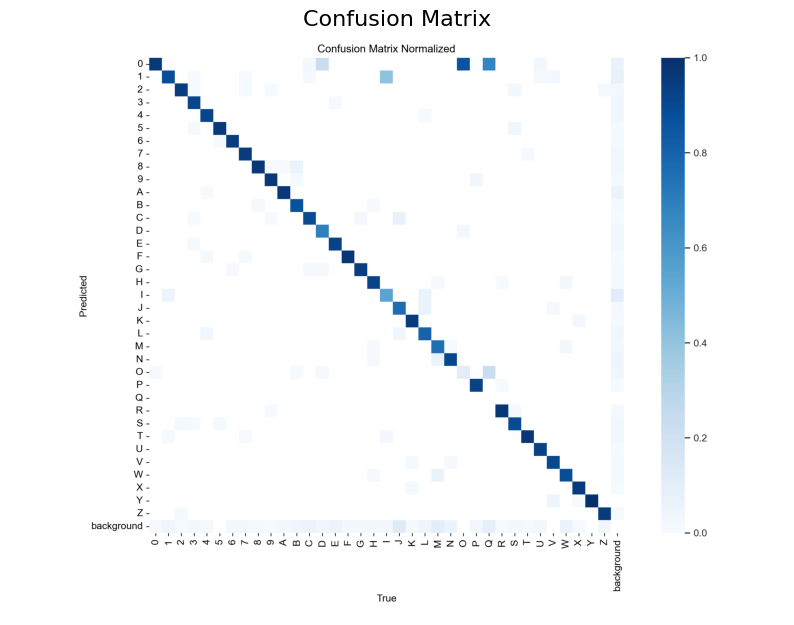

Sample Test Images:


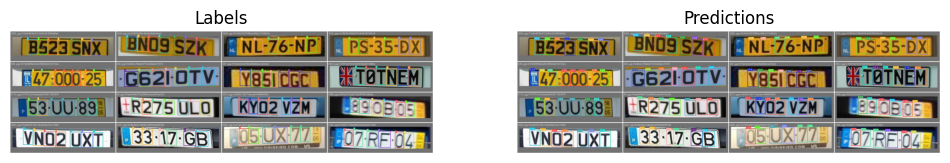

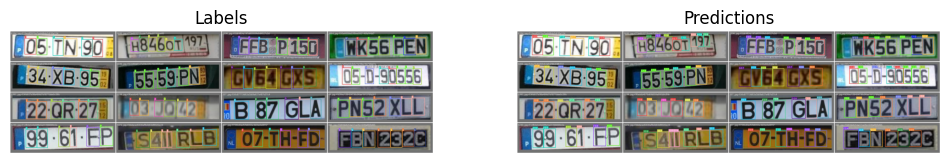

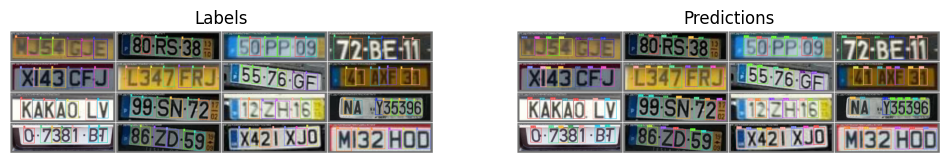

In [12]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

At mAP50 = 0.9187, our model exp3 is doing the same as model exp2. Therefore dropout 0.2 didn't have much of an effect. It might be due to the fact that ultralytics doesn't support dropout for detection tasks. Model exp 3 is struggling also with 0, Q, and O.

##### Experiment 4
- Testing following hyperparameter updates
    - Adding following augmentations: rotation, translation, perspective, mosaic, mixup

In [13]:
# loading pre-trained yolov8 model from ultralytics
model_exp4 = YOLO('yolov8n.pt')
# display the model architecture
model_exp4

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [14]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS = 10  # Number of training epochs
BATCH = 32  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 15  # Rotation degrees
TRANSLATE = 0.2  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 1e-5  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.1  # Mosaic data augmentation
MIXUP = 0.1  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = model_exp4.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_163900
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=10, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_163900, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\train\labels.cache... 4245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4245/4245 [00:00<?, ?it/s]

train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\03c3dfc7e998b8562_jpg.rf.3d9d76c2437bcfb5cf433c0b6306d1ac.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\185d5dfa193c4ced_jpg.rf.b3d2ab34086b9e8f050b514cc22b4b9a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\24c1fc0bf63da8153_jpg.rf.bd40f6e750b1a7990a9945aadddc1ef1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\421ca0ce7f9329622_jpg.rf.4e25470bde67152fea6834e88e803708.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\4572990fd64bb6be3_jpg.rf.7ce23d5cd8b919a7832485c4815d97c8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\train\images\492f6d607aae58c12_jpg.rf.44d8f6885cd8664eeff661809ad807ab.jpg: 1 duplicate labels removed
train: WARNING ⚠️ D:\Co


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\valid\labels.cache... 1221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1221/1221 [00:00<?, ?it/s]

val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\0ecee0dd32848030_jpg.rf.ffe2fb185ba29646fcf16eacf0e99021.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\22deb87614a920e6_jpg.rf.a72d572c1920415b880c030e7b1a17e6.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\dcb210b4cae8edf22_jpg.rf.286248320e4fe0f26c75339865578ccc.jpg: 1 duplicate labels removed
val: WARNING ⚠️ D:\College\Fall2023\DeepLearning\yolo_ocr\valid\images\f7f068d4fb49a4f34_jpg.rf.8856a3518481e9dcc022b1a802a966cd.jpg: 1 duplicate labels removed


Plotting labels to yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       4.4G       1.23       3.27      1.218        118        640: 100%|██████████| 133/133 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


                   all       1221       7890      0.313      0.132     0.0714      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.71G       1.12       1.98      1.131        123        640: 100%|██████████| 133/133 [00:37<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


                   all       1221       7890      0.569      0.633      0.628      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.69G      1.059      1.285      1.105        136        640: 100%|██████████| 133/133 [00:38<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


                   all       1221       7890      0.757      0.713      0.778      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.77G      1.012      1.003      1.079        123        640: 100%|██████████| 133/133 [00:37<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


                   all       1221       7890      0.789      0.771      0.835      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.69G     0.9665     0.8769      1.057        135        640: 100%|██████████| 133/133 [00:38<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


                   all       1221       7890      0.861      0.816      0.884       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.69G     0.9428     0.7828      1.044        125        640: 100%|██████████| 133/133 [00:39<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


                   all       1221       7890      0.895      0.842      0.905      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.69G     0.8809     0.7167      1.021        129        640: 100%|██████████| 133/133 [00:38<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


                   all       1221       7890       0.91      0.855      0.917       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.69G     0.8611     0.6625      1.013        113        640: 100%|██████████| 133/133 [00:49<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


                   all       1221       7890      0.913      0.857      0.925      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.69G     0.8417     0.6341     0.9993        113        640: 100%|██████████| 133/133 [00:40<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


                   all       1221       7890      0.913      0.856      0.936      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.69G      0.796     0.5867     0.9803        129        640: 100%|██████████| 133/133 [00:39<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


                   all       1221       7890      0.936      0.882      0.951      0.687

10 epochs completed in 0.161 hours.
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900\weights\last.pt, 6.3MB
Optimizer stripped from yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900\weights\best.pt, 6.3MB

Validating yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                   all       1221       7890      0.912      0.856      0.936      0.699
Speed: 0.8ms preprocess, 1.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_163900


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▂▅█▇▇▆▅▃▂▁
lr/pg2,▂▅█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▆▇▇██████
metrics/mAP50-95(B),▁▅▆▇▇▇▇███
metrics/precision(B),▁▄▆▇▇█████
metrics/recall(B),▁▆▇▇██████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▃▂▂▂▁


Training Results:


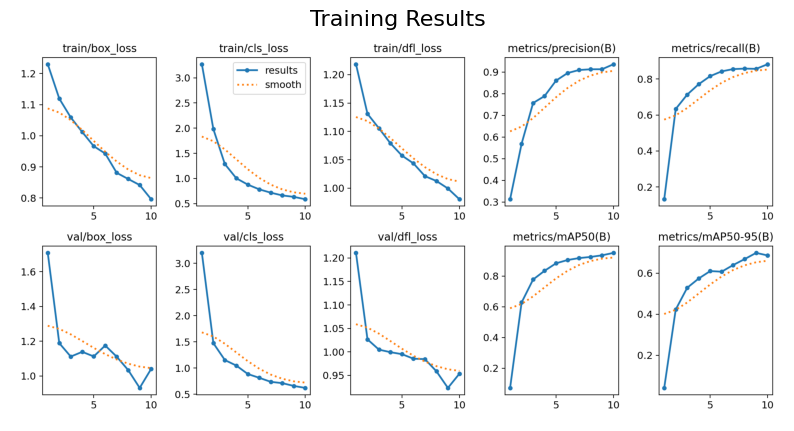

In [15]:
# display the sum training results
plot_training_results(training_results)

In [16]:
# Eval parameters
VAL_BATCH = 64
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = model_exp4.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\College\Fall2023\DeepLearning\yolo_ocr\test\labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


                   all        610       3954       0.85      0.881      0.918      0.682
Speed: 0.7ms preprocess, 3.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8n_ocr\baseline_yolov8n_ocr_20231206_1639002


In [17]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

Evaluation Results for baseline_yolov8n_ocr_20231206_163900:
metrics/precision(B): 0.8496
metrics/recall(B)   : 0.8808
metrics/mAP50(B)    : 0.9179
metrics/mAP50-95(B) : 0.6816
fitness             : 0.7053


Confusion Matrix:


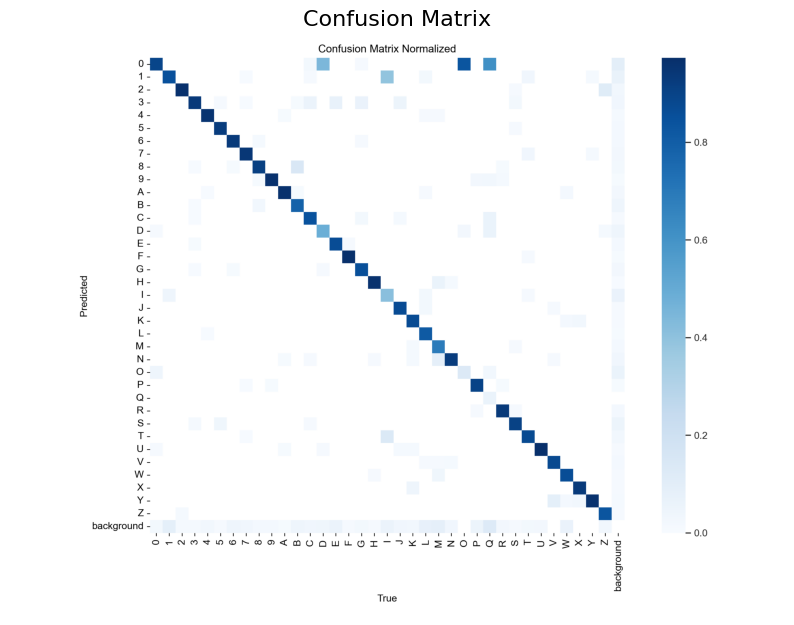

Sample Test Images:


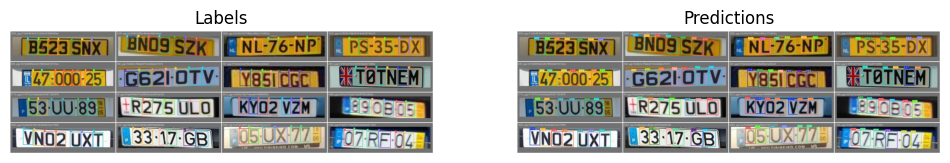

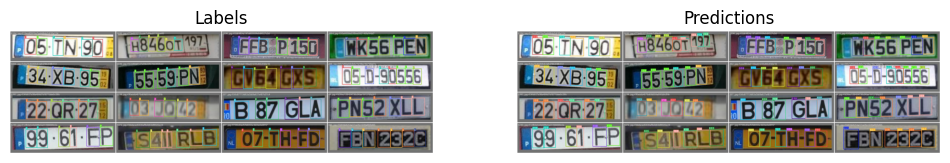

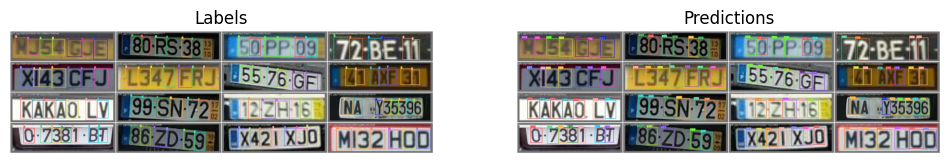

In [20]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

At mAP50 = 0.9179, our model exp4 is not doing better than model exp2 (0.9187), indicating that the added augmentation were not helpful. We can see from the confusion plot that this model exp 4 is also struggling with 0, O and Q. For the next run, we are going to use the same hyperparameters as model exp2 but with more epochs and 
a larger variant of Yolo V8 to see if it can overcome the struggle with 0, O and Q.

##### Final Run
- Here we will run for longer epochs based on what we have learned so far
    - Yolo V8 Large
    - max epoch is  25 epochs 
    - batch size is 8 which increases the stochasticity of the training and reduce the VRAM cost

In [7]:
# loading pre-trained yolov8 model from ultralytics
yolov8l = YOLO('yolov8l.pt')
# display the model architecture
yolov8l

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_r

In [ ]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS =  25  # Number of training epochs
BATCH = 8  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = yolov8l.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

baseline_yolov8n_ocr_20231206_181320
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.9.18 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=D:/College/Fall2023/DeepLearning/yolo_ocr/data.yaml, epochs=25, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n_ocr, name=baseline_yolov8n_ocr_20231206_181320, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

wandb: Currently logged in as: erud1t3. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


In [ ]:
# display the sum training results
plot_training_results(training_results)

In [ ]:
# Eval parameters
VAL_BATCH = 16
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = yolov8l.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

In [ ]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

In [ ]:
# visualization of results
plot_evaluation_results(test_results)

Discussion

At mAP50 = ..., our final model is .... However, we can see from the confusion plot that this model exp 2 is struggling with ...

### BONUS (25 bonus points)
- Design and train a custom CNN-based object detection model using a self-designed architecture.
     - Consider implementing Gaussian YOLO V8 using ultralytics.nn.modules
- Alternatively, compare several publicly available models on the same dataset.
    - Compare to Yolo V6 and RT-DETR fine-tuned on OCR dataset

##### Comparison

##### Yolo V6 Large

In [ ]:
# loading pre-trained yolov8 model from ultralytics
yolov6l = YOLO('yolov6-l.pt')
# display the model architecture
yolov6l

In [ ]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS =  25  # Number of training epochs
BATCH = 8  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = yolov6l.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

In [ ]:
# display the sum training results
plot_training_results(training_results)

In [ ]:
# Eval parameters
VAL_BATCH = 16
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = yolov6l.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

In [ ]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

In [ ]:
# visualization of results
plot_evaluation_results(test_results)

##### RT-DETR Large

In [ ]:
# loading pre-trained yolov8 model from ultralytics
rtdetrl = YOLO('rtdetr-l.pt')
# display the model architecture
rtdetrl

In [ ]:
# format timestamp as string
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# hyperparameters
IMGSZ = 640  # Image resolution for training
EPOCHS =  25  # Number of training epochs
BATCH = 8  # Batch size for training
PATIENCE = 50  # Early stopping patience in epochs
EXP_NAME = f'baseline_yolov8n_ocr_{timestamp}'  # Experiment name with timestamp
OPTIMIZER = 'AdamW'  # Optimization algorithm
VERBOSE = False  # Display detailed training info
FRACTION_TO_TRAIN = 1.0  # Fraction of training set to use
InitLR = 1e-3  # Initial learning rate
FinalLR = 5e-2  # Final learning rate
MOMENTUM = 0.937  # Momentum for optimizer
WEIGHT_DECAY = 5e-4  # Weight decay for regularization
BOX_GAIN = 7.5  # Weight for box loss
CLS_GAIN = 0.5  # Weight for class prediction loss
DFL_GAIN = 1.5  # Weight for directional feature loss
LABEL_SMOOTHING = 0.0  # Label smoothing value
DROPOUT = 0.0  # Dropout rate
USE_VAL = True  # Whether to use a validation set
SAVE_PLOTS = True  # Save training progress plots
USE_PRETRAINED = True  # Use pretrained model weights

# data augmentations
HSV_H = 0.015  # Hue shift (in HSV color space)
HSV_S = 0.7  # Saturation shift
HSV_V = 0.4  # Value (brightness) shift
DEGREES = 0.0  # Max Rotation degrees
TRANSLATE = 0.1  # Translation
SCALE = 0.5  # Scaling
SHEAR = 0.0  # Shearing
PERSPECTIVE = 0.0  # Perspective transformation
FLIPUD = 0.0  # Vertical flip
FLIPLR = 0.5  # Horizontal flip
MOSAIC = 0.0  # Mosaic data augmentation
MIXUP = 0.0  # Mixup data augmentation

# print experiment name
print(EXP_NAME)

# experiment is logged on Wandb
training_results = rtdetrl.train(
    # data
    data=local_ocr_ds_yaml_path,
    # hyperparameters
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT_NAME,
    name=EXP_NAME,
    optimizer=OPTIMIZER,
    verbose=VERBOSE,
    fraction=FRACTION_TO_TRAIN,
    lr0=InitLR,
    lrf=FinalLR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    box=BOX_GAIN,
    cls=CLS_GAIN,
    dfl=DFL_GAIN,
    label_smoothing=LABEL_SMOOTHING,
    dropout=DROPOUT,
    val=USE_VAL,
    plots=SAVE_PLOTS,
    pretrained=USE_PRETRAINED,
    seed=SEED,
    # data augmentations
    hsv_h=HSV_H,
    hsv_s=HSV_S,
    hsv_v=HSV_V,
    degrees=DEGREES,
    translate=TRANSLATE,
    scale=SCALE,
    shear=SHEAR,
    perspective=PERSPECTIVE,
    flipud=FLIPUD,
    fliplr=FLIPLR,
    mosaic=MOSAIC,
    mixup=MIXUP
)

In [ ]:
# display the sum training results
plot_training_results(training_results)

In [ ]:
# Eval parameters
VAL_BATCH = 16
VAL_PLOTS = True
VAL_SPLIT = 'test'
# evaluate the model on the test dataset
test_results = rtdetrl.val(
    data=local_ocr_ds_yaml_path,
    imgsz=IMGSZ,
    plots=VAL_PLOTS,
    split=VAL_SPLIT)

In [ ]:
# print evaluation results
print_evaluation_results(test_results, EXP_NAME)

In [ ]:
# visualization of results
plot_evaluation_results(test_results)

##### Custom Yolo V8: Gaussian Yolo V8

In [ ]:
import torch